In [48]:
#
import pandas as pd
import numpy as np
import json as json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [49]:
 # Loading the data from CSV into panadas dataframe
tempIncomeStatement = pd.read_csv (r'../data/income_statement.csv', sep=',')
tempMonthly = pd.read_csv (r'../data/monthly-data.csv', sep=',')
TickerSymbols = pd.read_csv (r'../data/nasdaq_screener_sorted_values.csv', sep=',')

In [50]:
print(tempIncomeStatement.shape)
print(tempIncomeStatement.columns)

(3904, 27)
Index(['fiscalDateEnding', 'reportedCurrency', 'grossProfit', 'totalRevenue',
       'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome',
       'sellingGeneralAndAdministrative', 'researchAndDevelopment',
       'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome',
       'interestIncome', 'interestExpense', 'nonInterestIncome',
       'otherNonOperatingIncome', 'depreciation',
       'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense',
       'interestAndDebtExpense', 'netIncomeFromContinuingOperations',
       'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'symbol'],
      dtype='object')


In [51]:
# renaming Balance sheet column "fiscalDateEnding" to "timestamp" to match column name on both dataframes
tempIncomeStatement = tempIncomeStatement.rename(columns={"fiscalDateEnding": "timestamp"})


# Daily dates does not overlap on both dataframes, CompanyMonthly has the last trading day (not including weekends)
# While CompanyBalanaceSheet always has the last day of the month (including weekends)
# We need to cut out the daily date for both dataframes["timestamp"], to be able to merge them properly.
# Slicing the timestamp in CompanyMonthly, removing the days
sliceMonthly = tempMonthly["timestamp"].str.slice(0, -3)
tempMonthly["timestamp"] = sliceMonthly

# Printing
print(tempMonthly["timestamp"])

# Slicing the timestamp in CompanyBalanceSheet, removing the days
sliceIncomestatement = tempIncomeStatement["timestamp"].str.slice(0, -3)
# For some reason i needed to use Iloc here, don't know why... 
tempIncomeStatement["timestamp"] = sliceIncomestatement

# Printing
print(tempIncomeStatement["timestamp"])

# printing
print(TickerSymbols["Symbol"])
    

0        2021-11
1        2021-10
2        2021-09
3        2021-08
4        2021-07
          ...   
43662    2000-11
43663    2000-10
43664    2000-09
43665    2000-08
43666    2000-07
Name: timestamp, Length: 43667, dtype: object
0       2021-09
1       2021-06
2       2021-03
3       2020-12
4       2020-09
         ...   
3899    2017-05
3900    2017-02
3901    2016-11
3902    2016-08
3903    2016-05
Name: timestamp, Length: 3904, dtype: object
0       AAPL
1       MSFT
2       GOOG
3      GOOGL
4       AMZN
       ...  
195     STLA
196      NIO
197      UBS
198     CRWD
199     MRVL
Name: Symbol, Length: 200, dtype: object


In [52]:
# for each company we want to make adjustments needed for each companys features and then we will merge them into one df

#------------ add error if ticker symbol is not in TickerSymbols["Symbol"] or size < 200


TickerSymbols = TickerSymbols[~TickerSymbols['Symbol'].isin(['RIVN'])]
final_df = pd.DataFrame()
counter = 0

for tickerSymbol in TickerSymbols["Symbol"]:
    counter = counter +1
    print("this is the beginning of the forloop, tickersymbol: " + tickerSymbol + "counter = " + str(counter))
    
    # filter both dataframes to only use a certain stock, in this case Apple (AAPL)
    CompanyIncomestatement = tempIncomeStatement.loc[tempIncomeStatement["symbol"] == tickerSymbol]
    CompanyMonthly = tempMonthly.loc[tempMonthly["Symbol"] == tickerSymbol]
    
    # Cutting out unecessary data from the CompanyMonthly
    # We only need price data in CompanyMonthly within the daterange of the 20 rows on CompanyBalanceSheet data
    # every row is 3 months in CompanyBalanceSheet. Every row in CompanyMonthly is 1 month, 3x20 = 60.
    idx = (CompanyMonthly.index[0]+60)
    CompanyMonthly = CompanyMonthly.loc[:idx]

    # calculating 1 month labels
    CompanyMonthly["1m"] = CompanyMonthly["close"].pct_change(periods = -1).shift(periods = 1)
    print(CompanyMonthly.head(21))
    
    # merging the rows from balance sheet and monthly on timestamp.
    merged_df = pd.merge(CompanyIncomestatement, CompanyMonthly, how="outer", on = "timestamp")
    
    # removing the rows over 20
    merged_df = merged_df.loc[:19]

    # calculate how much the increase is in percentage, interval of 3 months
    # also offsetting by 1, to get the labels on the correct row.
    cat = ["timestamp", "symbol", "close", "change"]
    merged_df["3m"] = merged_df["close"].pct_change(periods = -1).shift(periods = 1)
    
    # Removing the first row, because we do not have a label for it, 3 months have not passed yet for us to get the end price of the 3 month cycle
    #merged_df.drop(index=merged_df.index[0], axis=0, inplace=True)

    # Also dropping columns that we do not need, symbol, Symbol, open, high, low, close, volume etc.
    merged_df.drop(['symbol', 'Symbol', 'open','high','low','volume', "close", "timestamp", "reportedCurrency"], axis=1, inplace=True)

    # replacing all "None" strings with NaN data type
    merged_df = merged_df.replace('None', np.nan)

    # Checking for "None" Strings
    sub_df = merged_df.loc[: , (merged_df == 'None').any()]

    # Checking for "None" Strings
    sub_df = merged_df.loc[: , (merged_df == 'None').any()]
    print(sub_df)
    
    for col in merged_df.columns:
        if col != "timestamp":
            merged_df[col] = merged_df[col].astype("float")
            merged_df[col] = merged_df[col].replace(np.nan, merged_df[col].mean())
    
    # adding it to the final dataframe
    final_df = pd.concat([final_df, merged_df], axis=0)

this is the beginning of the forloop, tickersymbol: AAPLcounter = 1
   timestamp     open     high      low   close        volume Symbol        1m
0    2021-11  148.985  161.020  147.480  160.55  1.066135e+09   AAPL       NaN
1    2021-10    141.9  153.165  138.270  149.80  1.565079e+09   AAPL  0.071762
2    2021-09   152.83  157.260  141.270  141.50  1.797948e+09   AAPL  0.058657
3    2021-08   146.36  153.490  144.500  151.83  1.462773e+09   AAPL -0.068037
4    2021-07    136.6  150.000  135.760  145.86  1.916751e+09   AAPL  0.040930
5    2021-06   125.08  137.410  123.130  136.96  1.606114e+09   AAPL  0.064982
6    2021-05   132.04  134.070  122.250  124.61  1.711935e+09   AAPL  0.099109
7    2021-04   123.66  137.070  122.490  131.46  1.889957e+09   AAPL -0.052107
8    2021-03   123.75  128.720  116.210  122.15  2.650845e+09   AAPL  0.076218
9    2021-02   133.75  137.877  118.390  121.26  1.825487e+09   AAPL  0.007340
10   2021-01   133.52  145.090  126.382  131.96  2.239366e+09  

this is the beginning of the forloop, tickersymbol: AMZNcounter = 5
    timestamp      open       high        low    close       volume Symbol  \
827   2021-11    3361.8  3762.1450  3283.5500  3676.57   54507917.0   AMZN   
828   2021-10   3289.01  3479.0000  3176.2500  3372.43   63680713.0   AMZN   
829   2021-09  3496.396  3549.9900  3273.9900  3285.04   62540133.0   AMZN   
830   2021-08    3353.1  3472.5800  3175.7600  3470.79   62844829.0   AMZN   
831   2021-07   3434.61  3773.0782  3306.9800  3327.59   82554006.0   AMZN   
832   2021-06  3243.495  3524.8599  3172.2000  3440.16   66960544.0   AMZN   
833   2021-05   3484.73  3486.6450  3127.3700  3223.07   75191624.0   AMZN   
834   2021-04   3117.94  3554.0000  3115.5500  3467.42   76843571.0   AMZN   
835   2021-03   3127.89  3182.0000  2881.0001  3094.08   78204991.0   AMZN   
836   2021-02   3242.36  3434.0000  3036.7000  3092.93   70893385.0   AMZN   
837   2021-01    3270.0  3363.8900  3086.0000  3206.20   71427780.0   AMZN

     timestamp     open     high       low   close       volume Symbol  \
1606   2021-11   113.58  124.800  112.4100  124.26  126647342.0    TSM   
1607   2021-10    112.0  117.150  107.5800  113.70  154392359.0    TSM   
1608   2021-09  120.215  125.280  111.0200  111.65  149580110.0    TSM   
1609   2021-08    117.5  120.800  107.6800  119.01  172893465.0    TSM   
1610   2021-07    120.1  125.780  112.0455  116.64  185943677.0    TSM   
1611   2021-06   119.71  122.000  112.0100  120.16  178103811.0    TSM   
1612   2021-05   117.47  119.420  107.8700  117.36  166932877.0    TSM   
1613   2021-04   122.81  127.400  113.7700  116.74  214186535.0    TSM   
1614   2021-03   129.63  130.300  107.8900  118.28  296574297.0    TSM   
1615   2021-02   124.54  142.195  122.8300  125.94  215732725.0    TSM   
1616   2021-01   111.47  136.130  110.4450  121.52  322401541.0    TSM   
1617   2020-12    98.69  109.700   98.5200  109.04  164210945.0    TSM   
1618   2020-11     84.6  102.440   84.

     timestamp    open      high     low   close       volume Symbol        1m
2562   2021-11  461.82  466.0000  439.50  440.00   39338844.0    UNH       NaN
2563   2021-10   391.6  461.3900  383.12  460.47   60243412.0    UNH -0.044455
2564   2021-09  416.54  424.4000  390.46  390.74   59614464.0    UNH  0.178456
2565   2021-08  413.57  431.3550  404.30  416.27   47566823.0    UNH -0.061330
2566   2021-07  402.03  422.5300  401.81  412.22   51539661.0    UNH  0.009825
2567   2021-06  413.73  413.7300  387.25  400.44   82542898.0    UNH  0.029418
2568   2021-05   401.0  425.9800  400.53  411.92   49822954.0    UNH -0.027869
2569   2021-04   372.2  402.1600  360.55  398.80   56372667.0    UNH  0.032899
2570   2021-03  334.36  380.5000  332.67  372.07   79604224.0    UNH  0.071841
2571   2021-02  335.03  344.6385  320.35  332.22   68431649.0    UNH  0.119951
2572   2021-01  351.45  367.4900  329.01  333.58   63101362.0    UNH -0.004077
2573   2020-12  344.77  354.1000  329.40  350.68   6

     timestamp    open      high       low   close      volume Symbol  \
3968   2021-11  806.91  881.1200  796.4800  857.17  10032120.0   ASML   
3969   2021-10   745.0  821.9200  709.0300  812.88  22309987.0   ASML   
3970   2021-09  838.72  895.9300  742.2900  745.11  20902947.0   ASML   
3971   2021-08  770.81  844.1600  761.2100  833.04  11865803.0   ASML   
3972   2021-07  687.24  768.7000  664.8300  766.74  15882866.0   ASML   
3973   2021-06  684.74  710.9700  660.1100  690.84  14290115.0   ASML   
3974   2021-05  657.71  679.4438  600.2600  675.47  18274281.0   ASML   
3975   2021-04   619.8  675.6500  612.7800  648.10  20570251.0   ASML   
3976   2021-03  572.37  627.3000  501.1100  617.36  25842191.0   ASML   
3977   2021-02   547.4  608.7100  541.9500  567.09  14572418.0   ASML   
3978   2021-01  499.99  573.7987  489.7400  534.16  19393834.0   ASML   
3979   2020-12   447.1  492.6600  444.2600  487.72  12507023.0   ASML   
3980   2020-11  364.48  441.2900  361.7200  437.73 

this is the beginning of the forloop, tickersymbol: NFLXcounter = 23
     timestamp      open      high       low   close       volume Symbol  \
4946   2021-11    689.06  700.9894  642.1100  678.80   46407009.0   NFLX   
4947   2021-10    604.24  690.9699  594.6800  690.31   98581620.0   NFLX   
4948   2021-09     569.0  619.0000  568.0800  610.34   82338296.0   NFLX   
4949   2021-08     519.0  569.4800  505.3700  569.19   54707801.0   NFLX   
4950   2021-07    525.72  557.5399  504.6600  517.57   77194388.0   NFLX   
4951   2021-06    504.01  536.1300  482.1400  528.21   78536070.0   NFLX   
4952   2021-05    512.65  518.9500  478.5400  502.81   66932689.0   NFLX   
4953   2021-04    529.93  563.5600  499.0000  513.47  111580464.0   NFLX   
4954   2021-03  545.5734  556.9900  492.8500  521.66   90187968.0   NFLX   
4955   2021-02    536.79  566.6500  518.2800  538.85   61545689.0   NFLX   
4956   2021-01     539.0  593.2877  485.6701  532.39  139998993.0   NFLX   
4957   2020-12  492

this is the beginning of the forloop, tickersymbol: NKEcounter = 28
     timestamp    open    high       low   close       volume Symbol        1m
6174   2021-11   167.8  179.10  165.8900  174.88   79693339.0    NKE       NaN
6175   2021-10  145.22  167.63  144.3700  167.29  132974091.0    NKE  0.045370
6176   2021-09  164.92  166.62  144.4200  145.23  171241972.0    NKE  0.151897
6177   2021-08  169.06  174.38  164.2000  164.74   94300393.0    NKE -0.118429
6178   2021-07  154.07  167.87  153.8900  167.51  114640880.0    NKE -0.016536
6179   2021-06  137.85  156.40  126.6800  154.49  193637955.0    NKE  0.084277
6180   2021-05  133.37  139.36  130.4750  136.46  119864503.0    NKE  0.132127
6181   2021-04  134.69  138.24  125.7000  132.62  146687136.0    NKE  0.028955
6182   2021-03  135.64  146.66  125.4400  132.89  175615393.0    NKE -0.002032
6183   2021-02  135.37  145.88  131.5800  134.78  108986149.0    NKE -0.014023
6184   2021-01  142.85  147.10  130.2668  133.59   99233048.0  

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: LLYcounter = 34
     timestamp    open     high       low   close       volume Symbol  \
7758   2021-11  255.11  271.110  248.0500  260.70   40430339.0    LLY   
7759   2021-10   231.0  256.750  224.2200  254.76   53323088.0    LLY   
7760   2021-09  258.54  260.990  220.2000  231.05   61195782.0    LLY   
7761   2021-08  245.73  275.870  243.5000  258.29   54225049.0    LLY   
7762   2021-07  229.51  248.400  228.6600  243.50   50261821.0    LLY   
7763   2021-06  200.32  239.370  196.6800  229.52   95262441.0    LLY   
7764   2021-05  182.99  203.615  182.9200  199.74   60884540.0    LLY   
7765   2021-04  186.82  193.500  178.5779  182.77   63359486.0    LLY   
7766   2021-03  205.78  212.160  179.8200  186.82   96146254.0    LLY   
7767   2021-02  209.46  209.890  195.6400  204.89   62542908.0    LLY   
7768   2021-01  169.02 

this is the beginning of the forloop, tickersymbol: AVGOcounter = 38
     timestamp     open      high       low   close       volume Symbol  \
8626   2021-11  530.336  577.2100  524.9300  568.72   23293038.0   AVGO   
8627   2021-10   487.85  536.0700  472.7800  531.67   34166302.0   AVGO   
8628   2021-09   496.27  510.7000  484.4801  484.93   37313757.0   AVGO   
8629   2021-08   489.05  507.8500  462.6600  497.21   26436160.0   AVGO   
8630   2021-07   477.84  494.0200  455.7100  485.40   32332686.0   AVGO   
8631   2021-06   475.44  478.5900  458.4400  476.84   37593216.0   AVGO   
8632   2021-05   459.75  474.6200  419.1400  472.33   35504377.0   AVGO   
8633   2021-04   472.07  489.6350  449.0000  456.20   40559988.0   AVGO   
8634   2021-03    479.7  490.8599  419.2600  463.66   72481021.0   AVGO   
8635   2021-02   455.85  495.1400  453.5900  469.87   31612577.0   AVGO   
8636   2021-01   439.33  470.0000  420.5400  450.50   32133476.0   AVGO   
8637   2020-12   403.46  438.50

     timestamp     open     high      low   close       volume Symbol  \
9545   2021-11    161.2  166.430  160.180  163.81   53442389.0    PEP   
9546   2021-10   151.35  162.260  149.480  161.60   83985289.0    PEP   
9547   2021-09   156.84  158.190  150.100  150.41   83661881.0    PEP   
9548   2021-08    157.0  159.630  153.640  156.39   75267751.0    PEP   
9549   2021-07   148.08  158.660  147.770  156.95   95534048.0    PEP   
9550   2021-06   148.78  149.270  144.610  148.17  107241049.0    PEP   
9551   2021-05  145.028  148.770  143.490  147.94  100658263.0    PEP   
9552   2021-04   141.19  147.800  140.110  144.16  110117384.0    PEP   
9553   2021-03   130.61  144.960  128.320  141.45  161736796.0    PEP   
9554   2021-02   136.98  142.120  128.570  129.19   95889917.0    PEP   
9555   2021-01   147.01  147.780  136.015  136.57   94581878.0    PEP   
9556   2020-12   145.03  148.770  143.020  148.30   79832968.0    PEP   
9557   2020-11   135.61  146.565  133.780  144.23  

this is the beginning of the forloop, tickersymbol: MRKcounter = 47
      timestamp   open    high     low  close       volume Symbol        1m
10865   2021-11  88.05  91.400  79.881  80.70  201451184.0    MRK       NaN
10866   2021-10  81.56  88.460  77.110  88.05  420386637.0    MRK -0.083475
10867   2021-09  76.22  77.380  70.890  75.11  284872511.0    MRK  0.172281
10868   2021-08  76.93  79.230  74.815  76.29  181714786.0    MRK -0.015467
10869   2021-07  77.65  78.770  75.640  76.87  178624294.0    MRK -0.007545
10870   2021-06  76.06  78.090  72.075  77.77  322646212.0    MRK -0.011573
10871   2021-05  74.26  80.340  74.220  75.89  222004545.0    MRK  0.024773
10872   2021-04  77.16  79.490  72.850  74.50  234804770.0    MRK  0.018658
10873   2021-03  73.21  78.545  71.715  77.09  334019292.0    MRK -0.033597
10874   2021-02  77.99  78.920  72.540  72.62  211609492.0    MRK  0.061553
10875   2021-01   82.0  85.600  76.390  77.07  193599623.0    MRK -0.057740
10876   2020-12  80.

this is the beginning of the forloop, tickersymbol: WFCcounter = 52
      timestamp   open     high      low  close        volume Symbol        1m
11841   2021-11  51.56  52.5650  47.7700  48.82  3.229816e+08    WFC       NaN
11842   2021-10  46.55  51.6400  44.8300  51.16  5.160943e+08    WFC -0.045739
11843   2021-09   45.7  48.9400  43.2700  46.41  6.520906e+08    WFC  0.102349
11844   2021-08  46.04  51.4100  45.1100  45.70  5.286699e+08    WFC  0.015536
11845   2021-07  45.48  46.8529  41.9700  45.94  5.606713e+08    WFC -0.005224
11846   2021-06  47.16  47.4600  41.4700  45.29  6.072349e+08    WFC  0.014352
11847   2021-05  45.45  48.1300  44.6700  46.72  5.202123e+08    WFC -0.030608
11848   2021-04  38.96  46.3900  38.9200  45.05  6.345066e+08    WFC  0.037070
11849   2021-03  37.11  41.5400  36.3400  39.07  7.815674e+08    WFC  0.153059
11850   2021-02  30.14  38.6800  29.6800  36.17  6.536382e+08    WFC  0.080177
11851   2021-01  30.32  35.1000  29.4002  29.88  7.978371e+08  

12917  0.013273  
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: INTUcounter = 57
      timestamp    open     high       low   close      volume Symbol  \
13161   2021-11  628.53  716.860  603.5600  692.34  20454437.0   INTU   
13162   2021-10  541.24  626.600  519.0000  625.99  23104820.0   INTU   
13163   2021-09   567.3  579.170  539.2100  539.51  23870683.0   INTU   
13164   2021-08  532.11  582.960  524.2600  566.11  23482421.0   INTU   
13165   2021-07  493.68  532.330  487.2300  529.97  21089237.0   INTU   
13166   2021-06   441.7  492.600  434.6500  490.17  26611871.0   INTU   
13167   2021-05  414.79  445.655  385.6600  439.09  26912208.0   INTU   
13168   2021-04  388.92  422.770  388.4900  412.16  21303696.0   INTU   
13169   2021-03  396.33  407.860  365.1500  383.06  37259098.0   INTU   
13170   2021-02  365.49  423.740  364.5900  390.14  26352087.0   INTU   
1317

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: SEcounter = 61
      timestamp     open      high      low   close       volume Symbol  \
14217   2021-11   345.02  366.3200  296.290  309.99   56602898.0     SE   
14218   2021-10   313.88  372.6999  308.560  343.57   54770832.0     SE   
14219   2021-09    340.0  359.8400  311.180  318.73   83725151.0     SE   
14220   2021-08  279.795  344.7700  276.410  338.32   77756649.0     SE   
14221   2021-07    274.6  300.0000  253.030  276.16   54497331.0     SE   
14222   2021-06    257.7  297.7500  248.605  274.60   61811906.0     SE   
14223   2021-05    256.0  261.5000  200.000  253.24   86858599.0     SE   
14224   2021-04    228.5  278.0000  228.210  252.54   65108315.0     SE   
14225   2021-03   250.75  276.0200  189.610  223.23  131075133.0     SE   
14226   2021-02   222.97  285.0000  222.970  235.69   75118676.0     SE   
14

15078   2020-03   191.3  205.750  146.710  173.00  92771207.0    LIN  0.063526
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: SAPcounter = 66
      timestamp    open      high     low   close      volume Symbol        1m
15095   2021-11  145.65  149.9200  140.68  140.95   6602587.0    SAP       NaN
15096   2021-10   136.1  147.8800  132.98  144.78  13915403.0    SAP -0.026454
15097   2021-09  150.78  151.4800  134.95  135.04  10910474.0    SAP  0.072127
15098   2021-08  143.05  150.7500  142.75  150.14   9576920.0    SAP -0.100573
15099   2021-07  140.08  150.6300  136.09  143.72  15273898.0    SAP  0.044670
15100   2021-06   141.2  146.2900  137.48  140.46  11571177.0    SAP  0.023209
15101   2021-05   141.3  142.7300  134.57  139.93  12845322.0    SAP  0.003788
15102   2021-04  125.14  145.4200  124.95  139.94  21350672.0    SAP -0.000071
15103   2021-03   124.0  127.7000  1

this is the beginning of the forloop, tickersymbol: SCHWcounter = 70
      timestamp   open    high      low  close       volume Symbol        1m
15976   2021-11  82.55  83.850  78.8450  80.17   66880383.0   SCHW       NaN
15977   2021-10  72.97  84.490  72.0500  82.03  116964189.0   SCHW -0.022675
15978   2021-09  72.84  77.965  67.3101  72.84  109054804.0   SCHW  0.126167
15979   2021-08   68.2  76.000  66.1600  72.85  114545973.0   SCHW -0.000137
15980   2021-07  73.46  73.640  65.7300  67.95  145002234.0   SCHW  0.072112
15981   2021-06  74.94  76.370  69.2800  72.81  173833558.0   SCHW -0.066749
15982   2021-05  70.83  74.310  68.6600  73.85  134000804.0   SCHW -0.014083
15983   2021-04  65.14  72.160  63.4600  70.40  157966918.0   SCHW  0.049006
15984   2021-03  62.59  68.210  62.3300  65.18  173321291.0   SCHW  0.080086
15985   2021-02  52.13  65.430  51.9700  61.72  157879729.0   SCHW  0.056060
15986   2021-01  53.22  62.040  50.7650  51.54  194769312.0   SCHW  0.197516
15987  

      timestamp    open      high     low   close       volume Symbol  \
17207   2021-11   94.64   95.9400  89.470   90.40   56282036.0     PM   
17208   2021-10   95.17   99.7299  94.310   94.54   83391729.0     PM   
17209   2021-09  103.15  106.5100  94.370   94.79   99490687.0     PM   
17210   2021-08  100.64  103.6300  98.580  103.00   58854220.0     PM   
17211   2021-07   99.21  100.6300  93.940  100.09   79054576.0     PM   
17212   2021-06   97.01  100.9500  96.080   99.11  126389347.0     PM   
17213   2021-05   95.51   98.6200  94.595   96.43   72713784.0     PM   
17214   2021-04   88.42   95.6000  87.330   95.00   98505402.0     PM   
17215   2021-03   84.73   91.2500  84.302   88.74  114646505.0     PM   
17216   2021-02    79.0   88.1900  78.340   84.02   88900131.0     PM   
17217   2021-01   82.82   83.7500  79.440   79.65   92495136.0     PM   
17218   2020-12   76.02   86.6100  75.690   82.79  132252530.0     PM   
17219   2020-11   71.94   79.2100  70.125   75.75  

this is the beginning of the forloop, tickersymbol: NOWcounter = 80
      timestamp    open      high      low   close      volume Symbol  \
18305   2021-11   700.0  707.6000  663.820  675.97  12721436.0    NOW   
18306   2021-10  623.78  698.4300  609.470  697.76  23606376.0    NOW   
18307   2021-09   643.6  681.0999  607.180  622.27  21327453.0    NOW   
18308   2021-08  587.89  647.7000  566.590  643.64  19208745.0    NOW   
18309   2021-07   545.0  608.7800  539.745  587.89  23079416.0    NOW   
18310   2021-06   477.6  561.8900  456.000  549.55  31801590.0    NOW   
18311   2021-05  507.46  508.2209  448.270  473.88  34950387.0    NOW   
18312   2021-04   508.0  565.2900  500.280  506.37  32671046.0    NOW   
18313   2021-03  544.82  562.4300  462.505  500.11  41050301.0    NOW   
18314   2021-02  546.01  598.3700  521.150  533.46  24720557.0    NOW   
18315   2021-01  556.94  563.8799  507.060  543.16  30530142.0    NOW   
18316   2020-12   536.0  566.7400  518.510  550.43  2556

this is the beginning of the forloop, tickersymbol: BMYcounter = 85
      timestamp   open     high      low  close       volume Symbol        1m
19300   2021-11   58.3  60.2000  57.8000  57.83  163015151.0    BMY       NaN
19301   2021-10  59.37  60.0250  56.1100  58.40  253979145.0    BMY -0.009760
19302   2021-09  67.29  67.2900  59.1500  59.17  220801906.0    BMY -0.013013
19303   2021-08   68.2  69.7500  66.5100  66.86  152250732.0    BMY -0.115016
19304   2021-07  66.42  69.2700  65.7800  67.87  181215182.0    BMY -0.014881
19305   2021-06   66.4  67.9400  63.2200  66.82  219846935.0    BMY  0.015714
19306   2021-05   62.7  67.9600  62.6501  65.72  190629985.0    BMY  0.016738
19307   2021-04  63.18  66.9300  61.5100  62.42  236873713.0    BMY  0.052868
19308   2021-03   61.9  64.4150  58.6250  63.13  284392857.0    BMY -0.011247
19309   2021-02  61.91  64.6350  59.3700  61.33  260131077.0    BMY  0.029349
19310   2021-01  61.74  67.1599  60.4650  61.43  236934452.0    BMY -0.001

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: RTXcounter = 90
      timestamp   open     high      low  close       volume Symbol        1m
20600   2021-11  88.91   91.670  85.0600  85.43   62822735.0    RTX       NaN
20601   2021-10   86.8   92.320  86.1400  88.86   94983125.0    RTX -0.038600
20602   2021-09  85.14   88.470  81.5200  85.96  123765123.0    RTX  0.033737
20603   2021-08  87.14   88.740  82.9650  84.76   83121268.0    RTX  0.014158
20604   2021-07  85.42   89.460  79.7200  86.95  102358763.0    RTX -0.025187
20605   2021-06  89.81   89.980  84.1400  85.31  119634606.0    RTX  0.019224
20606   2021-05   83.8   88.830  82.1400  88.71  132838799.0    RTX -0.038327
20607   2021-04  77.61   83.800  76.0705  83.24  140902748.0    RTX  0.065714
20608   2021-03  73.51   80.060  72.7400  77.27  166879376.0    RTX  0.077262
20609   2021-02   67.6   78.170  66.1300  71.9

this is the beginning of the forloop, tickersymbol: BBLcounter = 94
      timestamp   open    high     low  close      volume Symbol        1m
21649   2021-11  52.92  53.460  50.340  50.80  30869051.0    BBL       NaN
21650   2021-10   50.7  56.115  49.800  52.98  48399578.0    BBL -0.041148
21651   2021-09  61.54  62.240  49.500  50.69  67797264.0    BBL  0.045177
21652   2021-08  66.14  67.650  58.805  62.64  60270574.0    BBL -0.190773
21653   2021-07  60.27  67.010  58.720  65.29  34492918.0    BBL -0.040588
21654   2021-06  62.67  63.070  55.800  59.69  35507336.0    BBL  0.093818
21655   2021-05  61.09  68.045  58.500  60.75  38151465.0    BBL -0.017449
21656   2021-04  58.04  63.000  57.140  60.50  29489218.0    BBL  0.004132
21657   2021-03  63.97  66.590  54.800  57.86  53580729.0    BBL  0.045627
21658   2021-02  56.79  67.030  55.020  63.23  29566207.0    BBL -0.084928
21659   2021-01  55.57  60.970  54.530  54.62  30195589.0    BBL  0.157635
21660   2020-12   46.6  54.410  

      timestamp    open      high      low   close      volume Symbol  \
22894   2021-11  199.85  210.1500  199.840  208.71   3069053.0    DEO   
22895   2021-10  192.47  202.0950  189.930  199.67   5236600.0    DEO   
22896   2021-09  195.85  197.1150  185.985  193.00   6696178.0    DEO   
22897   2021-08  199.15  202.3500  190.180  192.11   8173184.0    DEO   
22898   2021-07  191.72  200.0000  186.390  198.21   7562431.0    DEO   
22899   2021-06  194.21  197.6700  190.670  191.69   7985829.0    DEO   
22900   2021-05  180.29  193.7000  179.220  193.25   7306618.0    DEO   
22901   2021-04  166.94  183.7300  165.780  179.35   9167501.0    DEO   
22902   2021-03  159.08  170.3900  158.770  164.21   8959723.0    DEO   
22903   2021-02  161.07  170.3700  156.660  157.74  10325347.0    DEO   
22904   2021-01  162.97  165.5200  153.670  160.27   8261522.0    DEO   
22905   2020-12  157.88  165.4200  154.485  158.81   7242707.0    DEO   
22906   2020-11  130.77  162.3600  129.500  154.95 

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: DEcounter = 105
      timestamp    open      high       low   close      volume Symbol  \
23975   2021-11  347.12  366.2000  335.4500  346.15  22967518.0     DE   
23976   2021-10   338.1  353.8500  320.5000  342.31  30228840.0     DE   
23977   2021-09   378.2  393.0000  333.7300  335.07  42811847.0     DE   
23978   2021-08   363.9  388.5200  344.7600  378.03  30402599.0     DE   
23979   2021-07  355.66  362.1100  328.9300  361.59  27955410.0     DE   
23980   2021-06  364.41  369.2500  321.9018  352.71  48271674.0     DE   
23981   2021-05   376.5  400.3399  350.5300  361.10  37234896.0     DE   
23982   2021-04  375.63  386.0600  365.6000  370.85  26821584.0     DE   
23983   2021-03  355.06  392.4200  330.7800  374.14  44705659.0     DE   
23984   2021-02  292.12  354.4080  289.6500  349.12  37341116.0     DE   
23985   2021

      timestamp    open     high     low   close        volume Symbol  \
24826   2021-11  105.76  116.165   99.18   99.96  1.189930e+08     GE   
24827   2021-10  104.18  110.970  101.18  104.87  1.371689e+08     GE   
24828   2021-09  105.36  107.360   96.21  103.03  2.115865e+08     GE   
24829   2021-08  104.48  107.230   98.11  105.41  2.020825e+08     GE   
24830   2021-07   13.58   13.630   11.82   12.95  1.222271e+09     GE   
24831   2021-06   14.23   14.370   12.75   13.46  1.176529e+09     GE   
24832   2021-05   13.24   14.400   12.72   14.06  1.322265e+09     GE   
24833   2021-04   13.23   14.000   12.77   13.12  1.239172e+09     GE   
24834   2021-03   12.92   14.415   11.95   13.13  2.344386e+09     GE   
24835   2021-02   10.86   13.350   10.64   12.54  1.242213e+09     GE   
24836   2021-01   10.89   12.230   10.40   10.68  1.686244e+09     GE   
24837   2020-12   10.33   11.490   10.01   10.80  1.764136e+09     GE   
24838   2020-11     7.5   10.850    7.33   10.18  2

      timestamp    open     high       low   close      volume Symbol  \
25571   2021-11  436.31  439.200  413.2600  415.21  15787978.0   ANTM   
25572   2021-10  374.34  439.900  363.3700  435.13  23978068.0   ANTM   
25573   2021-09  374.91  391.432  355.4333  372.80  24356866.0   ANTM   
25574   2021-08  385.34  397.950  363.9400  375.13  20117217.0   ANTM   
25575   2021-07  383.12  402.230  373.6700  384.01  24540242.0   ANTM   
25576   2021-06  398.96  399.440  368.3400  381.80  22696169.0   ANTM   
25577   2021-05  383.43  406.000  382.0800  398.22  19904576.0   ANTM   
25578   2021-04  359.93  386.780  349.0500  379.39  21334247.0   ANTM   
25579   2021-03  307.66  379.130  306.3600  358.95  34421610.0   ANTM   
25580   2021-02  298.97  313.850  286.0400  303.19  26340264.0   ANTM   
25581   2021-01  321.11  340.980  288.0100  296.98  24737372.0   ANTM   
25582   2020-12   317.0  326.900  298.6000  321.09  23841293.0   ANTM   
25583   2020-11  278.19  338.200  270.4400  311.52 

this is the beginning of the forloop, tickersymbol: MRNAcounter = 119
      timestamp      open      high       low   close       volume Symbol  \
26661   2021-11    334.99  350.1000  210.9600  263.78  202602443.0   MRNA   
26662   2021-10    358.33  359.1150  293.5800  345.21  239916628.0   MRNA   
26663   2021-09   382.837  464.8500  375.2000  384.86  284798615.0   MRNA   
26664   2021-08     360.0  497.4900  343.2000  376.69  483123851.0   MRNA   
26665   2021-07     236.3  362.0000  214.0700  353.60  415576869.0   MRNA   
26666   2021-06    184.08  245.7000  178.8000  234.98  210600803.0   MRNA   
26667   2021-05     183.9  189.0000  143.5600  185.01  188520962.0   MRNA   
26668   2021-04     132.2  186.8000  127.0400  178.82  207970994.0   MRNA   
26669   2021-03  154.4631  157.7799  117.3411  130.95  205766386.0   MRNA   
26670   2021-02    173.03  189.2600  136.0000  154.81  197135870.0   MRNA   
26671   2021-01    107.23  185.9800  103.2600  173.16  343597736.0   MRNA   
26672 

      timestamp   open    high     low  close      volume Symbol        1m
27488   2021-11  63.25  63.670  59.580  62.01  57562623.0    RIO       NaN
27489   2021-10  66.76  71.350  63.120  63.27  71888039.0    RIO -0.019915
27490   2021-09  74.09  76.740  64.235  66.82  88718075.0    RIO -0.053128
27491   2021-08  88.06  89.390  71.570  75.07  56219571.0    RIO -0.109897
27492   2021-07  84.04  89.510  78.950  86.31  44344539.0    RIO -0.130228
27493   2021-06  90.37  91.090  80.610  83.89  47336967.0    RIO  0.028847
27494   2021-05  86.03  95.970  83.460  87.43  59046269.0    RIO -0.040490
27495   2021-04  77.41  88.285  76.520  85.06  50746937.0    RIO  0.027863
27496   2021-03  88.21  91.890  73.610  77.65  64185977.0    RIO  0.095428
27497   2021-02  78.63  92.850  76.470  87.40  42100498.0    RIO -0.111556
27498   2021-01  78.98  86.900  76.180  76.42  38324502.0    RIO  0.143680
27499   2020-12  66.26  77.640  66.260  75.22  42420397.0    RIO  0.015953
27500   2020-11  57.78  6

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: CNIcounter = 129
      timestamp     open     high     low   close      volume Symbol        1m
28940   2021-11   133.63  134.070  126.79  129.33  12698795.0    CNI       NaN
28941   2021-10  115.875  136.220  115.58  132.91  28842221.0    CNI -0.026936
28942   2021-09   116.93  128.410  113.11  115.65  71224708.0    CNI  0.149243
28943   2021-08   108.98  120.635  104.67  117.63  41862876.0    CNI -0.016832
28944   2021-07   105.66  108.660  100.66  108.63  35297157.0    CNI  0.082850
28945   2021-06   112.93  113.360  103.92  105.52  38394665.0    CNI  0.029473
28946   2021-05   108.57  114.630  101.50  112.57  55914474.0    CNI -0.062628
28947   2021-04   116.57  119.610  107.13  107.65  29928570.0    CNI  0.045704
28948   2021-03   110.47  119.350  108.60  115.98  25213913.0    CNI -0.071823
28949   2021-02   102.18  112.750  

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: COINcounter = 134
      timestamp      open    high     low   close       volume Symbol  \
30241   2021-11  324.7723  368.90  310.67  315.48   94995386.0   COIN   
30242   2021-10  232.8869  328.48  224.51  319.42  130187281.0   COIN   
30243   2021-09  260.3127  280.61  225.04  227.48   69789215.0   COIN   
30244   2021-08    237.28  294.00  226.91  259.00  103525280.0   COIN   
30245   2021-07    251.09  256.99  213.22  236.58   72957016.0   COIN   
30246   2021-06    238.51  261.15  210.77  253.30   93072155.0   COIN   
30247   2021-05     304.0  306.98  208.00  236.54  164798412.0   COIN   

             1m  
30241       NaN  
30242 -0.012335  
30243  0.404167  
30244 -0.121699  
30245  0.094767  
30246 -0.066009  
30247  0.070855  
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
this is the beginning

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: PNCcounter = 139
      timestamp    open      high       low   close      volume Symbol  \
31304   2021-11  212.97  213.5800  195.7800  204.15  21689504.0    PNC   
31305   2021-10  194.53  217.6000  193.9400  211.03  36812414.0    PNC   
31306   2021-09  191.75  202.1800  181.6800  195.64  37070455.0    PNC   
31307   2021-08  183.53  195.3300  180.4300  191.10  32342412.0    PNC   
31308   2021-07  191.47  193.5466  176.4300  182.41  32108740.0    PNC   
31309   2021-06  197.77  198.3800  177.6850  190.76  35093124.0    PNC   
31310   2021-05  188.67  203.8782  186.0800  194.68  34447947.0    PNC   
31311   2021-04  174.45  189.4250  170.1398  186.95  37351983.0    PNC   
31312   2021-03  171.37  184.3300  168.4400  175.41  47141585.0    PNC   
31313   2021-02  144.74  180.8500  143.6900  168.36  33479584.0    PNC   
31314   202

      timestamp    open    high     low   close      volume Symbol        1m
31918   2021-11   167.0  170.81  160.19  169.27  24978359.0    MMC       NaN
31919   2021-10  152.15  171.13  151.37  166.80  43402916.0    MMC  0.014808
31920   2021-09  156.87  162.26  151.36  151.43  37589925.0    MMC  0.101499
31921   2021-08  148.07  157.68  147.58  157.20  36113140.0    MMC -0.036705
31922   2021-07  141.15  149.30  137.85  147.22  45434355.0    MMC  0.067790
31923   2021-06   139.0  141.41  133.86  140.68  46042441.0    MMC  0.046488
31924   2021-05   136.1  139.22  131.96  138.35  32674201.0    MMC  0.016841
31925   2021-04  121.78  137.12  121.31  135.70  31774428.0    MMC  0.019528
31926   2021-03  115.62  122.09  112.98  121.80  44961125.0    MMC  0.114122
31927   2021-02  110.73  119.93  109.97  115.22  32140946.0    MMC  0.057108
31928   2021-01  116.43  116.81  106.95  109.91  34720210.0    MMC  0.048312
31929   2020-12  115.35  119.31  112.54  117.00  36176425.0    MMC -0.060598

this is the beginning of the forloop, tickersymbol: MOcounter = 148
      timestamp    open     high     low  close       volume Symbol        1m
33011   2021-11   44.21  45.4300  43.320  43.99  116177553.0     MO       NaN
33012   2021-10   45.47  49.0000  44.095  44.11  157529771.0     MO -0.002720
33013   2021-09  50.425  51.0800  45.370  45.52  157280591.0     MO -0.030975
33014   2021-08   48.24  50.3250  46.820  50.23  115622259.0     MO -0.093769
33015   2021-07   47.67  49.0100  46.125  48.04  138275121.0     MO  0.045587
33016   2021-06   49.58  50.5500  45.940  47.68  174374881.0     MO  0.007550
33017   2021-05   48.07  51.1400  47.620  49.22  136437764.0     MO -0.031288
33018   2021-04    51.0  52.5500  45.160  47.75  245326412.0     MO  0.030785
33019   2021-03   44.15  52.5900  44.010  51.16  269904977.0     MO -0.066654
33020   2021-02   41.08  45.3371  40.460  43.60  151063231.0     MO  0.173394
33021   2021-01   41.08  43.0400  40.000  41.08  154121838.0     MO  0.061

this is the beginning of the forloop, tickersymbol: BNScounter = 153
      timestamp   open    high      low  close      volume Symbol        1m
34294   2021-11  66.18  67.120  64.7900  64.80  13822505.0    BNS       NaN
34295   2021-10  61.57  67.260  61.0400  65.56  22408135.0    BNS -0.011592
34296   2021-09  62.26  62.765  59.0500  61.53  23824586.0    BNS  0.065497
34297   2021-08  62.55  64.950  61.4900  61.91  22120884.0    BNS -0.006138
34298   2021-07  65.39  65.690  59.9700  62.44  27205455.0    BNS -0.008488
34299   2021-06  67.92  68.020  63.6800  65.07  31550165.0    BNS -0.040418
34300   2021-05  63.89  67.465  63.2700  67.30  29291868.0    BNS -0.033135
34301   2021-04  62.67  64.120  60.5050  63.69  29108215.0    BNS  0.056681
34302   2021-03  59.37  64.380  58.8700  62.55  34801402.0    BNS  0.018225
34303   2021-02  53.57  61.350  53.3100  58.29  22918876.0    BNS  0.073083
34304   2021-01  53.61  56.020  52.7500  53.29  27085222.0    BNS  0.093826
34305   2020-12  49

this is the beginning of the forloop, tickersymbol: DUKcounter = 160
      timestamp    open      high       low   close       volume Symbol  \
35328   2021-11  102.13  102.9500   97.9600  100.25   42125232.0    DUK   
35329   2021-10    98.2  104.9400   97.6100  102.01   50712986.0    DUK   
35330   2021-09   104.9  106.9500   96.5800   97.59   68580363.0    DUK   
35331   2021-08  105.39  108.3800  104.3350  104.66   56066050.0    DUK   
35332   2021-07   98.96  106.7100   98.3500  105.11   54435648.0    DUK   
35333   2021-06  100.54  103.9000   97.6750   98.72   64471498.0    DUK   
35334   2021-05  100.82  108.0000   98.6500  100.22   76644863.0    DUK   
35335   2021-04   96.43  101.8300   95.3400  100.69   67567644.0    DUK   
35336   2021-03    86.0   97.9150   85.8043   96.53   91824065.0    DUK   
35337   2021-02   94.05   95.4500   85.5600   85.59   54666884.0    DUK   
35338   2021-01   91.78   94.5800   87.6203   94.00   53144947.0    DUK   
35339   2020-12   93.56   94.64

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: MCOcounter = 165
      timestamp    open     high      low   close      volume Symbol        1m
36107   2021-11  406.82  407.940  382.220  384.57   9962100.0    MCO       NaN
36108   2021-10   357.5  407.730  346.880  404.15  11078062.0    MCO -0.048447
36109   2021-09  380.31  387.740  353.030  355.11  10595542.0    MCO  0.138098
36110   2021-08  378.57  388.810  369.000  380.77  10800343.0    MCO -0.067390
36111   2021-07   362.5  384.520  361.020  376.00  12437381.0    MCO  0.012686
36112   2021-06  338.06  367.950  330.375  362.37  12537939.0    MCO  0.037613
36113   2021-05  327.53  338.590  318.930  335.35  13957862.0    MCO  0.080573
36114   2021-04   303.9  340.160  300.990  326.71  16725771.0    MCO  0.026445
36115   2021-03  277.33  307.860  275.990  298.61  18857653.0    MCO  0.094103
36116   2021-02  270.19  284.990  2

      timestamp     open       high        low    close      volume Symbol  \
37159   2021-11  1485.58  1711.0200  1311.6800  1314.83   9952107.0   MELI   
37160   2021-10  1692.15  1700.3900  1452.3901  1481.02   8140642.0   MELI   
37161   2021-09   1878.0  1970.1300  1641.0100  1679.40   6341319.0   MELI   
37162   2021-08  1587.91  1910.0000  1539.7400  1867.45   8504587.0   MELI   
37163   2021-07  1554.39  1651.7950  1471.2300  1568.70   5889733.0   MELI   
37164   2021-06  1371.79  1584.8722  1300.4400  1557.79   8473242.0   MELI   
37165   2021-05   1579.0  1625.0600  1262.3800  1358.67  10722962.0   MELI   
37166   2021-04  1518.74  1649.9100  1462.0000  1570.98   7782323.0   MELI   
37167   2021-03  1691.03  1724.2300  1337.9500  1472.14  15703187.0   MELI   
37168   2021-02  1812.58  2006.7100  1575.0001  1638.11   9067181.0   MELI   
37169   2021-01  1690.99  2020.0000  1564.9500  1779.51  12804131.0   MELI   
37170   2020-12  1556.04  1735.7500  1483.3400  1675.22   913286

this is the beginning of the forloop, tickersymbol: ABBcounter = 174
      timestamp   open     high      low  close      volume Symbol        1m
38360   2021-11  33.35  36.0800  33.2000  35.62  21350827.0    ABB       NaN
38361   2021-10  33.17  35.0600  32.4200  33.04  31857285.0    ABB  0.078087
38362   2021-09  37.01  37.8400  33.3142  33.36  25047840.0    ABB -0.009592
38363   2021-08  36.53  38.0300  36.3950  36.99  26904828.0    ABB -0.098135
38364   2021-07  34.04  37.0400  33.8900  36.62  26981172.0    ABB  0.010104
38365   2021-06  34.84  35.2800  32.8000  33.99  26210912.0    ABB  0.077376
38366   2021-05  32.85  34.3200  32.2950  34.14  30857167.0    ABB -0.004394
38367   2021-04  30.49  33.4800  30.4250  32.43  26503939.0    ABB  0.052729
38368   2021-03  29.25  31.7500  28.6600  30.47  43898772.0    ABB  0.064326
38369   2021-02  29.79  30.6400  28.6150  28.78  37391899.0    ABB  0.058721
38370   2021-01  28.63  30.8850  28.1950  29.51  44088847.0    ABB -0.024737
38371  

      timestamp    open      high       low   close       volume Symbol  \
39395   2021-11   165.2  175.7200  163.2600  172.32   22094052.0    ETN   
39396   2021-10  149.72  165.9600  147.3501  164.76   28132127.0    ETN   
39397   2021-09  168.22  168.4100  149.2500  149.31   38306234.0    ETN   
39398   2021-08  158.59  171.3200  156.4900  168.36   31036499.0    ETN   
39399   2021-07  149.88  158.6900  146.9900  158.05   35279937.0    ETN   
39400   2021-06  146.98  149.0500  139.1200  148.18   34399403.0    ETN   
39401   2021-05  144.93  149.3750  140.5200  145.25   37968734.0    ETN   
39402   2021-04  139.03  145.9500  137.5600  142.93   35353621.0    ETN   
39403   2021-03  132.01  141.3703  131.3000  138.28   64396180.0    ETN   
39404   2021-02   119.0  133.9191  118.3300  130.19   46726679.0    ETN   
39405   2021-01   120.3  130.0000  114.0100  117.70   38862960.0    ETN   
39406   2020-12  122.58  123.4300  113.7900  120.14   37975860.0    ETN   
39407   2020-11  105.76  

      timestamp    open      high       low   close       volume Symbol  \
40458   2021-11  223.36  238.9300  221.6800  234.54   13376796.0    ECL   
40459   2021-10  210.29  230.8926  209.1400  222.22   21219953.0    ECL   
40460   2021-09  225.02  231.2500  208.5700  208.62   20820696.0    ECL   
40461   2021-08  222.38  226.5600  217.0500  225.36   14981102.0    ECL   
40462   2021-07  206.92  222.6400  205.3000  220.83   22303100.0    ECL   
40463   2021-06   217.0  217.4700  204.2825  205.97   26002098.0    ECL   
40464   2021-05  225.52  230.0000  211.3600  215.08   23879313.0    ECL   
40465   2021-04  215.25  229.0500  213.7100  224.12   17043546.0    ECL   
40466   2021-03   210.8  219.8400  201.1470  214.07   26166772.0    ECL   
40467   2021-02  205.34  220.0000  204.6900  209.36   17726419.0    ECL   
40468   2021-01   218.0  227.9700  201.5500  204.51   17933875.0    ECL   
40469   2020-12  224.97  227.2900  210.7900  216.36   18443806.0    ECL   
40470   2020-11  186.59  

this is the beginning of the forloop, tickersymbol: CLcounter = 188
      timestamp   open    high      low  close       volume Symbol        1m
41348   2021-11  75.99  78.775  75.5700  77.56   55461822.0     CL       NaN
41349   2021-10  75.85  77.450  74.0100  76.19   96000287.0     CL  0.017981
41350   2021-09  77.84  78.560  75.4100  75.58   76886710.0     CL  0.008071
41351   2021-08  79.49  80.720  76.9850  77.95   75348174.0     CL -0.030404
41352   2021-07   81.5  84.960  79.2250  79.50   86880299.0     CL -0.019497
41353   2021-06  84.95  85.010  80.2100  81.35   90741023.0     CL -0.022741
41354   2021-05  80.84  84.910  80.1855  83.78   74113124.0     CL -0.029005
41355   2021-04  78.53  82.050  77.5800  80.70   92792753.0     CL  0.038166
41356   2021-03  75.44  79.975  74.1410  78.83  126761568.0     CL  0.023722
41357   2021-02  78.64  80.130  75.1500  75.20   76643416.0     CL  0.048271
41358   2021-01  84.78  85.555  77.8400  78.00  105458687.0     CL -0.035897
41359   

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: PBRcounter = 193
      timestamp   open     high     low  close        volume Symbol        1m
42603   2021-11   9.99  10.4200   9.475   9.77  3.997771e+08    PBR       NaN
42604   2021-10  10.43  11.1900   9.360   9.82  6.760556e+08    PBR -0.005092
42605   2021-09  10.67  11.0052   9.200  10.34  5.825776e+08    PBR -0.050290
42606   2021-08  10.81  11.6900   9.760  10.84  6.035317e+08    PBR -0.046125
42607   2021-07  12.38  12.3800   9.975  10.67  4.759945e+08    PBR  0.015933
42608   2021-06  10.54  12.2800  10.330  12.23  1.011166e+09    PBR -0.127555
42609   2021-05   8.49  10.2350   8.250  10.21  6.318166e+08    PBR  0.197845
42610   2021-04   8.42   8.8350   7.910   8.48  6.233201e+08    PBR  0.204009
42611   2021-03   7.95   8.6100   7.060   8.48  1.004602e+09    PBR  0.000000
42612   2021-02  10.18  11.4750   7.770   7.9

this is the beginning of the forloop, tickersymbol: MRVLcounter = 199
      timestamp     open   high      low  close       volume Symbol        1m
43410   2021-11    68.67  76.12  67.7700  72.75   94569561.0   MRVL       NaN
43411   2021-10     60.8  69.09  56.8600  68.50  142408545.0   MRVL  0.062044
43412   2021-09    61.62  63.98  59.3900  60.31   95440074.0   MRVL  0.135798
43413   2021-08     61.0  64.07  57.1044  61.19  127484237.0   MRVL -0.014381
43414   2021-07    57.97  60.60  52.7900  60.51  114328568.0   MRVL  0.011238
43415   2021-06    48.74  58.95  46.7700  58.33  185036361.0   MRVL  0.037374
43416   2021-05    45.48  49.21  40.7900  48.30  168081179.0   MRVL  0.207660
43417   2021-04     49.7  51.49  45.0400  45.21  205252931.0   MRVL  0.068348
43418   2021-03  49.0855  49.88  37.9200  48.98  320050806.0   MRVL -0.076970
43419   2021-02    52.06  54.56  46.1400  48.28  188541580.0   MRVL  0.014499
43420   2021-01    47.81  55.70  45.8400  51.46  176478075.0   MRVL -0.0

In [53]:
print(final_df)
print(final_df.columns)
print(final_df.dtypes)
cat = ["1m", "3m"]
print(final_df[cat].head(20))


     grossProfit  totalRevenue  costOfRevenue  costofGoodsAndServicesSold  \
0   3.517400e+10  8.268800e+10   5.380200e+10                4.818600e+10   
1   3.525500e+10  8.076900e+10   5.159100e+10                4.617900e+10   
2   3.807900e+10  8.891400e+10   5.681900e+10                5.150500e+10   
3   4.432800e+10  1.108010e+11   7.274200e+10                6.711100e+10   
4   2.468900e+10  6.469800e+10   4.494500e+10                4.000900e+10   
..           ...           ...            ...                         ...   
15  3.652000e+08  6.048000e+08   2.396000e+08                2.396000e+08   
16  3.455000e+08  5.727000e+08   2.272000e+08                2.272000e+08   
17  3.259000e+08  5.664000e+08   2.404000e+08                2.404000e+08   
18  3.569000e+08  6.237000e+08   2.668000e+08                2.668000e+08   
19  3.269000e+08  5.973000e+08   2.704000e+08                2.704000e+08   

    operatingIncome  sellingGeneralAndAdministrative  researchAndDevelopmen

In [54]:
print(final_df["1m"].isna().sum())
print(final_df["3m"].isna().sum())

0
0


1m                                   1.000000
3m                                   0.459397
investmentIncomeNet                  0.019190
researchAndDevelopment               0.011041
comprehensiveIncomeNetOfTax          0.000935
costOfRevenue                       -0.005502
costofGoodsAndServicesSold          -0.005576
operatingExpenses                   -0.007565
netIncomeFromContinuingOperations   -0.009100
depreciationAndAmortization         -0.010635
ebit                                -0.012356
operatingIncome                     -0.012583
interestExpense                     -0.012899
netIncome                           -0.013623
sellingGeneralAndAdministrative     -0.014012
nonInterestIncome                   -0.015140
ebitda                              -0.016001
interestIncome                      -0.016040
totalRevenue                        -0.016346
incomeBeforeTax                     -0.016884
netInterestIncome                   -0.017106
grossProfit                       

<AxesSubplot:>

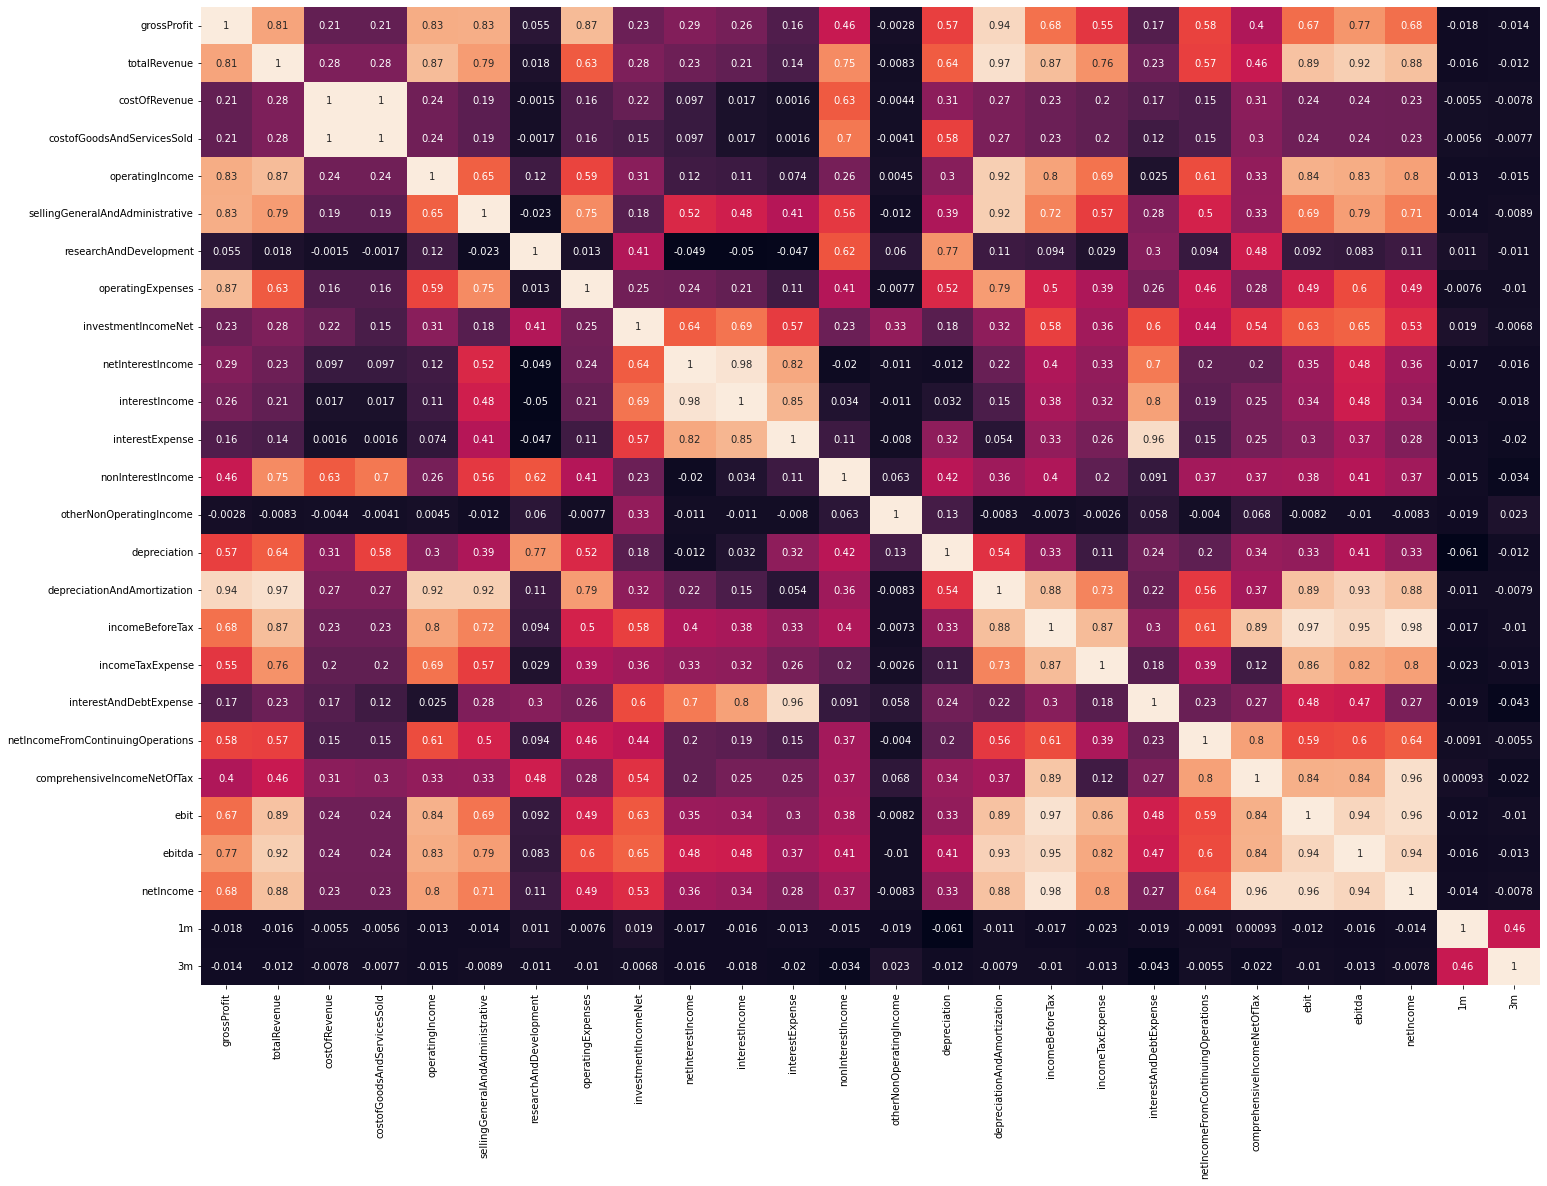

In [57]:
# correlation calculation
feature_corr = final_df.copy().corr()

# sorting and using 1m
sortedDesc = feature_corr["1m"].sort_values(ascending=False) 
print(sortedDesc)

#cf_matrix = confusion_matrix(feature_corr)
plt.figure(figsize = (24,18))
sns.heatmap(feature_corr, annot=True, cbar=False, )

3m                                   1.000000
1m                                   0.459397
otherNonOperatingIncome              0.022896
netIncomeFromContinuingOperations   -0.005505
investmentIncomeNet                 -0.006761
costofGoodsAndServicesSold          -0.007744
costOfRevenue                       -0.007766
netIncome                           -0.007785
depreciationAndAmortization         -0.007924
sellingGeneralAndAdministrative     -0.008923
incomeBeforeTax                     -0.010017
ebit                                -0.010330
operatingExpenses                   -0.010333
researchAndDevelopment              -0.010964
totalRevenue                        -0.011522
depreciation                        -0.011604
incomeTaxExpense                    -0.012588
ebitda                              -0.013246
grossProfit                         -0.014094
operatingIncome                     -0.015057
netInterestIncome                   -0.015845
interestIncome                    

<AxesSubplot:>

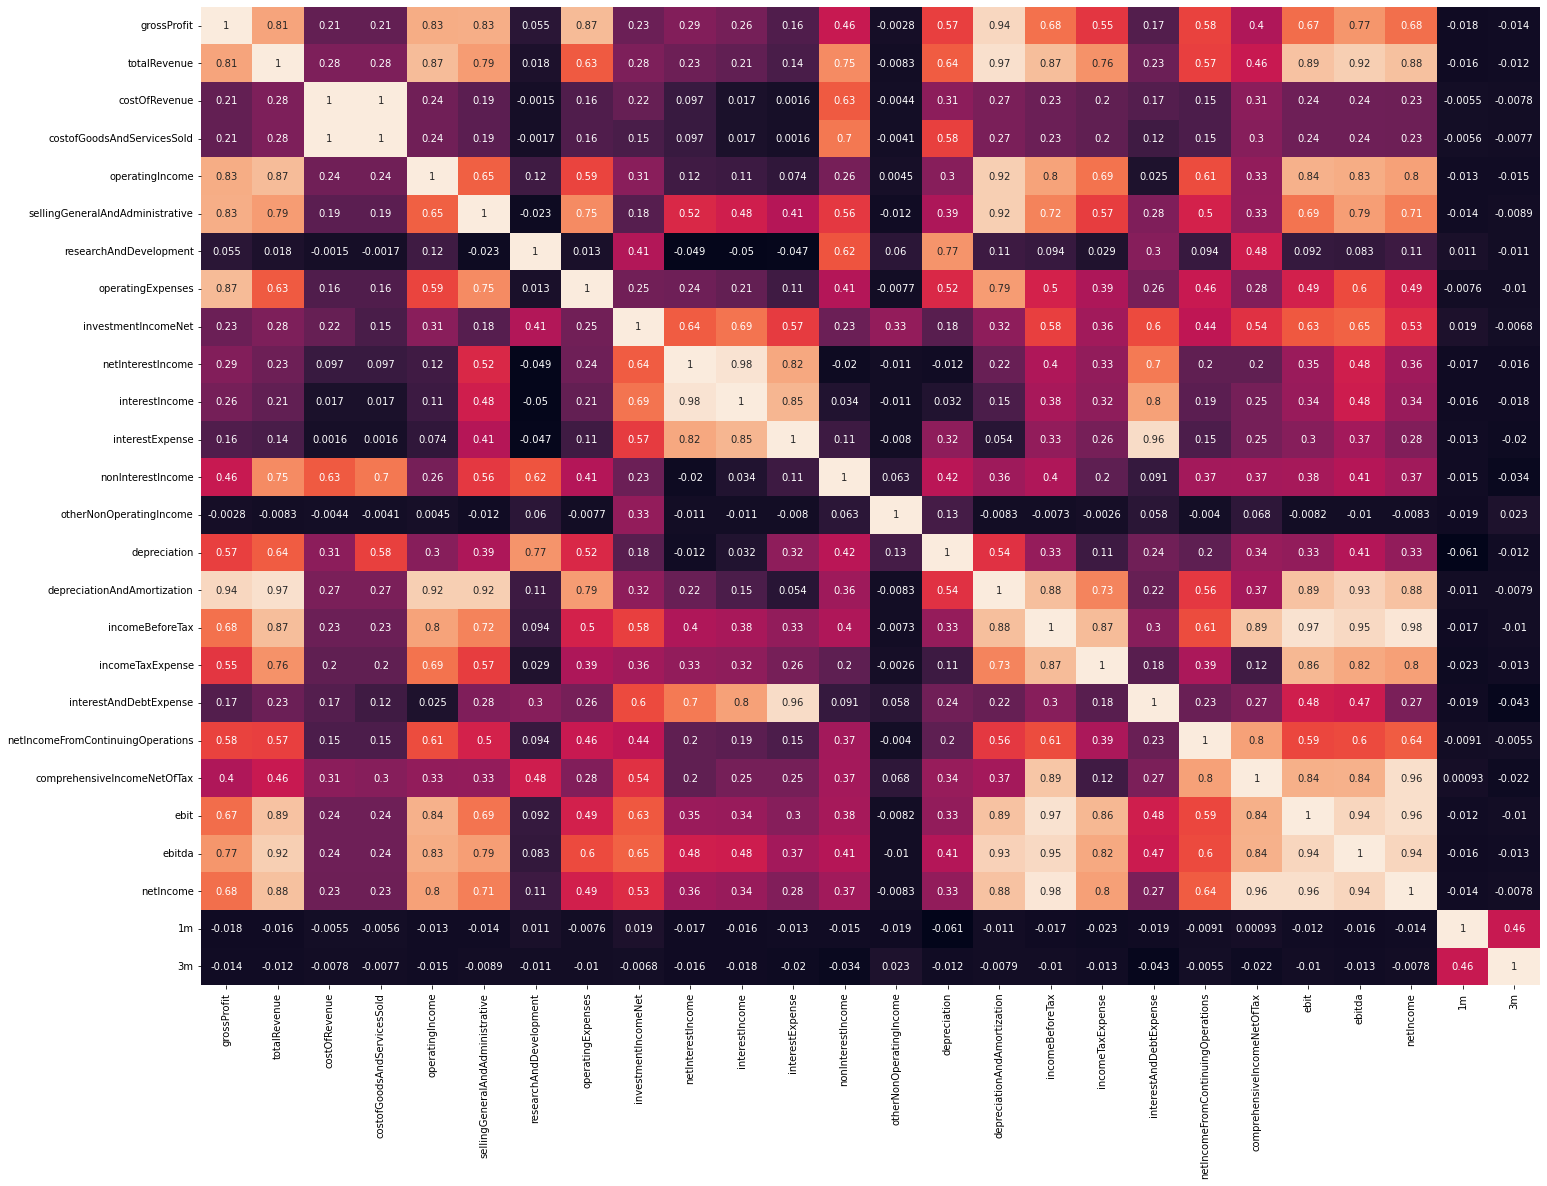

In [58]:
# sorting and using 3m
sortedDesc = feature_corr["3m"].sort_values(ascending=False) 
print(sortedDesc)

#cf_matrix = confusion_matrix(feature_corr)
plt.figure(figsize = (24,18))
sns.heatmap(feature_corr, annot=True, cbar=False, )